# Battle of Neighborhoods - Korean Restaurant in MidWest

In [1]:
import numpy as np 
import pandas as pd 

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
#!pip install folium
import folium 
import csv 

### FourSqare API parameters

In [2]:
CLIENT_ID = 'U0L3S4LVVVEMZ3D3DRK5KXSJXJQX1JOBJQL41HSU2HKMH1Q5'
CLIENT_SECRET = 'UL4J5C4JAWYTXTIRPDD4G4KPNSAH4DGUGSZVEGPW2FOSZOWD'
VERSION = '20180605'
Korean_restaurant_ID = '4bf58dd8d48988d113941735' #foursquare catergory ID

### Searching Korean Restaurants in 5 cities on Midwest from FourSqare

In [3]:
LIMIT = 500 # Maximum is 100
cities = ["St. Paul, MN", 'Chicago, IL', 'Indianapolis, IN', 'Columbus, OH', 'Detroit, MI']
results = {}
for city in cities:
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        city,
        LIMIT,
        Korean_restaurant_ID) 
    results[city] = requests.get(url).json()

In [4]:
df_venues={}
for city in cities:
    venues = json_normalize(results[city]['response']['groups'][0]['items'])
    df_venues[city] = venues[['venue.name', 'venue.location.address', 'venue.location.lat', 'venue.location.lng']]
    df_venues[city].columns = ['Name', 'Address', 'Lat', 'Lng']

### Create Data Frame Korean restaurant Densities

In [5]:
column_names = ['City','Numbers']
KoreanNumber = pd.DataFrame(columns = column_names)

### Creating Maps of five cities with Korean Restaurant locations

In [6]:
maps={}
for city in cities:
    city_lat = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lat']])
    city_lng = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lng']])
    maps[city] = folium.Map(width=500,height=300,location=[city_lat, city_lng], zoom_start=10)

    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])  
    n = results[city]['response']['totalResults']    
    KoreanNumber=KoreanNumber.append({'City': city,'Numbers': n},ignore_index=True)
KoreanNumber

,City,Numbers
0,"St. Paul, MN",23
1,"Chicago, IL",123
2,"Indianapolis, IN",11
3,"Columbus, OH",21
4,"Detroit, MI",22


### Showing Maps

In [7]:
maps[cities[0]]

In [8]:
maps[cities[1]]

In [9]:
maps[cities[2]]

In [10]:
maps[cities[3]]

In [11]:
maps[cities[4]]

### Not only the number of Korean Restaurants, Distances and Populations

Obviously, Chicago has the most korean Restaurants. 
However, it is because Chicago has the highest korean and Asian population.

We need compare the numbers of potential customers, Asisn population.<br>
We need to quantify **the density** of the restaurant in two ways, <br>
-**By the average destance** <br>
-**By the number per person (Asian)** 

### Calculating average restaurant distance from the center 

In [12]:
column_names = ['City','AverageDistance']
KoreanDist = pd.DataFrame(columns = column_names)

maps = {}

for city in cities:
    city_lat = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lat'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lat']])
    city_lng = np.mean([results[city]['response']['geocode']['geometry']['bounds']['ne']['lng'],
                        results[city]['response']['geocode']['geometry']['bounds']['sw']['lng']])
    maps[city] = folium.Map(width=500,height=300,location=[city_lat, city_lng], zoom_start=11)
    venues_mean_coor = [df_venues[city]['Lat'].mean(), df_venues[city]['Lng'].mean()] 
    # add markers to map
    for lat, lng, label in zip(df_venues[city]['Lat'], df_venues[city]['Lng'], df_venues[city]['Name']):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(maps[city])
        folium.PolyLine([venues_mean_coor, [lat, lng]], color="green", weight=1.5, opacity=0.5).add_to(maps[city])
    
    label = folium.Popup("Mean Co-ordinate", parse_html=True)
    folium.CircleMarker(
        venues_mean_coor,
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(maps[city])

    #print(city)
    #print("Average Distance from the center")
    #print(np.mean(np.apply_along_axis(lambda x: np.linalg.norm(x - venues_mean_coor),1,df_venues[city][['Lat','Lng']].values)))
    Dist = np.mean(np.apply_along_axis(lambda x: np.linalg.norm(x - venues_mean_coor),1,df_venues[city][['Lat','Lng']].values))
    KoreanDist = KoreanDist.append({'City':city,'AverageDistance':Dist},ignore_index=True)
KoreanDist

,City,AverageDistance
0,"St. Paul, MN",0.104295
1,"Chicago, IL",0.056442
2,"Indianapolis, IN",0.124167
3,"Columbus, OH",0.091155
4,"Detroit, MI",0.145858


In [13]:
maps[cities[0]]

In [14]:
maps[cities[1]]

In [15]:
maps[cities[2]]

In [16]:
maps[cities[3]]

In [17]:
maps[cities[4]]

### Merge Number data and Average Distance data 
### Adding Asisn Population information from https://worldpopulationreview.com/us-cities

|City|Asian Population|
|----|----|
|St. Paul|55,669|
|Chicago|175,109|
|Indianapolis|27,717|
|Columbus|49,616|
|Detroit|10,659|

In [18]:
KoreanDensity = pd.merge(KoreanNumber, KoreanDist, on='City')
KoreanDensity['AsianPopulation'] = [55669,175109,27717,49616,10659]

### Calculating Density with Populations
### For all scores, The greater the better location for new Korean Restaurant 

Density score of Average Distance = Average Distance$\times$ Asain Population <br>

Population score, Number of asains per restaurants $ = \frac{\textrm{Asian Population}} {\textrm{Number of restaurants}}$<br>

Total Density score $= \frac{\textrm{Average Distance}\times \textrm{Asian Population}}{\textrm{Number of restaurants} }$


In [19]:
KoreanDensity['Distance_Score']=KoreanDensity.AverageDistance*KoreanDensity.AsianPopulation
KoreanDensity['population_score']=KoreanDensity.AsianPopulation/KoreanDensity.Numbers
KoreanDensity['Total_Density']=KoreanDensity.AverageDistance/KoreanDensity.AsianPopulation/KoreanDensity.Numbers
KoreanDensity

,City,Numbers,AverageDistance,AsianPopulation,Distance_Score,population_score,Total_Density
0,"St. Paul, MN",23,0.104295,55669,5805.993664,2420.39,8.14558e-08
1,"Chicago, IL",123,0.056442,175109,9883.520014,1423.65,2.62053e-09
2,"Indianapolis, IN",11,0.124167,27717,3441.543668,2519.73,4.07257e-07
3,"Columbus, OH",21,0.091155,49616,4522.738429,2362.67,8.7486e-08
4,"Detroit, MI",22,0.145858,10659,1554.697762,484.5,6.22e-07


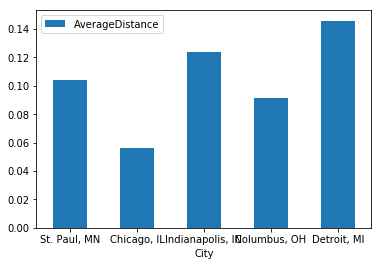

In [20]:
ax = KoreanDensity.plot.bar(x ='City',y='AverageDistance', rot=0)

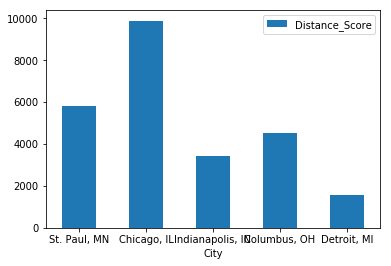

In [21]:
ax = KoreanDensity.plot.bar(x ='City',y='Distance_Score', rot=0)

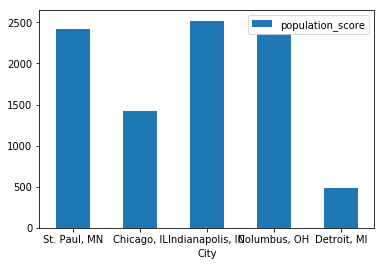

In [22]:
ax = KoreanDensity.plot.bar(x ='City',y='population_score', rot=0)

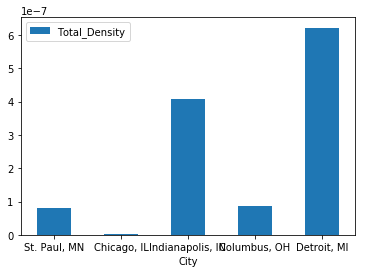

In [23]:
ax = KoreanDensity.plot.bar(x ='City',y='Total_Density', rot=0)

-Average Distance from the center itslef can be a good indicator.<br>
-Distance score doesn't consider the number of restaurant at all. Not a good measure of low competition. <br>
-Number of Asian population per restaurant could be a good indicator of low ompetition.<br>
-And, considering all three measures(average distance, Number of restaurant, Population) can be good measure, however, the scales of each measure are a lot different, we should not take the score as it is. <br>

### By considering all the scores, it seems Indianapolis is the best city for new Korean Restaurnt. 